## Import Libraries

In [16]:
import pandas as pd
import numpy as np
import os
import requests
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import squarify 
from wordcloud import WordCloud 

% matplotlib inline
sns.set(style = 'white')
pd.options.display.float_format = '{0:,.2f}'.format

## Data Gathering

### CSV Data: Twitter Archive

In [17]:
twitter_df = pd.read_csv('twitter-archive-enhanced-2.csv')
twitter_df.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,nan,nan,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,nan,nan,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,nan,nan,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,nan,nan,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,nan,nan,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


### Internet Data: Prediction Data

In [18]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

In [19]:
response = requests.get(url)

In [20]:
with open('image_predictions.tsv','wb') as predictions_file:
    predictions_file.write(response.content)

In [21]:
predict_df = pd.read_csv('image_predictions.tsv', sep = '\t')

In [22]:
predict_df.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.47,True,collie,0.16,True,Shetland_sheepdog,0.06,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.51,True,miniature_pinscher,0.07,True,Rhodesian_ridgeback,0.07,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.60,True,malinois,0.14,True,bloodhound,0.12,True


### Twitter Data

In [ ]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

In [ ]:
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

In [ ]:
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
count = 0
fails_dict = {}
start = timer()

In [ ]:
with open('tweet_json.txt', 'w') as outfile:
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [24]:
dfcolumns = ['tweet_id','retweet_count','favorite_count']
df_list = []
with open('tweet_json.txt','r',encoding='utf-8') as file: 
    for line in file:
        line_data = json.loads(line)
        df_list.append({'tweet_id':line_data.get('id'),
                       'retweet_count':line_data.get('retweet_count'),
                       'favorite_count':line_data.get('favorite_count')})
tweet_df = pd.DataFrame(df_list,columns=dfcolumns)
tweet_df.head(3)
            

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461


## Twitter Archive Cleanup

### Backup Data

In [25]:
df = twitter_df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

### Remove Unneeded Columns

<b>Define:</b>
A number of columns available in the original data input, will not be used in the analysis.
As a first step in the data wrangling process we will remove any data which will not be used going forward. 

<b>Fix:</b>

In [26]:
#Select the columns to drop
drop_columns = ['timestamp','source','retweeted_status_timestamp','expanded_urls']
df.drop(columns = drop_columns,inplace=True)

<b>Test</b>

In [27]:
df.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,nan,nan,This is Phineas. He's a mystical boy. Only eve...,nan,nan,13,10,Phineas,None,None,None,None
1,892177421306343426,nan,nan,This is Tilly. She's just checking pup on you....,nan,nan,13,10,Tilly,None,None,None,None
2,891815181378084864,nan,nan,This is Archie. He is a rare Norwegian Pouncin...,nan,nan,12,10,Archie,None,None,None,None


### Refactor Dog Stage Data

<b>Define:</b>
The stage of the dog is a categorical variable currently stored over four different columns. 
The goal is to compress the data into a single column which will store one of the four potential values. 

<b>Fix:</b>

In [28]:
#create the new column by merging the values
df['dog_stage'] = df.doggo+df.floofer+df.pupper+df.puppo

In [29]:
#replace the None sequence so as to leave only the real type
df.dog_stage = df.dog_stage.str.replace('None','')

In [30]:
#replace blank with nan so as to identify missing values easier
df.dog_stage.replace('',np.nan,inplace=True)

In [31]:
#drop the old columns
df.drop(columns=['doggo','floofer','pupper','puppo'],inplace=True)

<b>Test:</b>

In [32]:
df.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,nan,nan,This is Phineas. He's a mystical boy. Only eve...,nan,nan,13,10,Phineas,NaN
1,892177421306343426,nan,nan,This is Tilly. She's just checking pup on you....,nan,nan,13,10,Tilly,NaN
2,891815181378084864,nan,nan,This is Archie. He is a rare Norwegian Pouncin...,nan,nan,12,10,Archie,NaN
3,891689557279858688,nan,nan,This is Darla. She commenced a snooze mid meal...,nan,nan,13,10,Darla,NaN
4,891327558926688256,nan,nan,This is Franklin. He would like you to stop ca...,nan,nan,12,10,Franklin,NaN


### Cleanup Denominator Data

<b>Define:</b>
It is expected that all ratings are formatted as x / 10, therefore the denominator should always be 10. 
The goal is to check this is the case and on a case by case basis fix the potential issues. 

<b>Fix:</b>

In [33]:
df[df.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,name,dog_stage
313,835246439529840640,"835,245,984,028,504,064.00","26,259,576.00",@jonnysun @Lin_Manuel ok jomny I know you're e...,nan,nan,960,0,None,NaN
342,832088576586297345,"832,087,547,559,997,440.00","30,582,082.00",@docmisterio account started on 11/15/15,nan,nan,11,15,None,NaN
433,820690176645140481,nan,nan,The floofs have been released I repeat the flo...,nan,nan,84,70,None,NaN
516,810984652412424192,nan,nan,Meet Sam. She smiles 24/7 &amp; secretly aspir...,nan,nan,24,7,Sam,NaN
784,775096608509886464,nan,nan,"RT @dog_rates: After so many requests, this is...","740,373,189,193,256,960.00","4,196,983,835.00",9,11,None,NaN
902,758467244762497024,nan,nan,Why does this never happen at my front door......,nan,nan,165,150,None,NaN
1068,740373189193256964,nan,nan,"After so many requests, this is Bretagne. She ...",nan,nan,9,11,None,NaN
1120,731156023742988288,nan,nan,Say hello to this unbelievably well behaved sq...,nan,nan,204,170,this,NaN
1165,722974582966214656,nan,nan,Happy 4/20 from the squad! 13/10 for all https...,nan,nan,4,20,None,NaN
1202,716439118184652801,nan,nan,This is Bluebert. He just saw that both #Final...,nan,nan,50,50,Bluebert,NaN


In most cases the problem is that the tweet is about a whole group of dogs. 
We are going to remove all rows where the denominator is not 10 and the name of the dog is missing, as this will not help with the analysis done further on the data.

In [34]:
df.drop(df[(df.rating_denominator != 10) & (df.name == 'None')].index, inplace=True)

<b>Test 1:</b>

In [35]:
#Test the rows are not there
df[(df.rating_denominator != 10) & (df.name == 'None')].index

Int64Index([], dtype='int64')

<b>Fix 2a:</b>

In [36]:
#checking the remaining cases
df[df.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,name,dog_stage
516,810984652412424192,nan,nan,Meet Sam. She smiles 24/7 &amp; secretly aspir...,nan,nan,24,7,Sam,NaN
1120,731156023742988288,nan,nan,Say hello to this unbelievably well behaved sq...,nan,nan,204,170,this,NaN
1202,716439118184652801,nan,nan,This is Bluebert. He just saw that both #Final...,nan,nan,50,50,Bluebert,NaN
1351,704054845121142784,nan,nan,Here is a whole flock of puppers. 60/50 I'll ...,nan,nan,60,50,a,NaN
1662,682962037429899265,nan,nan,This is Darrel. He just robbed a 7/11 and is i...,nan,nan,7,11,Darrel,NaN
2335,666287406224695296,nan,nan,This is an Albanian 3 1/2 legged Episcopalian...,nan,nan,1,2,an,NaN


In [37]:
#By looking at the text we can manually discard the following rows 
#as they are either belonging to group of dogs or to dogs with missing name or rating: 
drop_rows = [516,1120,1351,2335]
df.drop(drop_rows,inplace=True)

<b>Fix 2b:</b>

In [38]:
#checking the remaining cases
df[df.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,name,dog_stage
1202,716439118184652801,nan,nan,This is Bluebert. He just saw that both #Final...,nan,nan,50,50,Bluebert,NaN
1662,682962037429899265,nan,nan,This is Darrel. He just robbed a 7/11 and is i...,nan,nan,7,11,Darrel,NaN


In [39]:
#For the remaining two cases we need to fix the rating as it's incorrect:
#Bluebert is a 11/10
#Darrel is a 10/10
df.rating_denominator = 10
df.at[1202,'rating_numerator'] = 11
df.at[1662,'rating_numerator'] = 10

<b>Test 2:</b>

In [40]:
#Final test should return 0
df[df.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,name,dog_stage


<b>Define:</b>
Once all entries have the expected denominator (10) the column becomse redundant and can be incorporated into
a single rating column. 

<b>Fix:</b>

In [41]:
df['rating'] = df.rating_numerator / df.rating_denominator

In [42]:
df.drop(columns=['rating_denominator','rating_numerator'],inplace=True)

<b>Test:</b>

In [43]:
df.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,name,dog_stage,rating
0,892420643555336193,nan,nan,This is Phineas. He's a mystical boy. Only eve...,nan,nan,Phineas,NaN,1.30
1,892177421306343426,nan,nan,This is Tilly. She's just checking pup on you....,nan,nan,Tilly,NaN,1.30
2,891815181378084864,nan,nan,This is Archie. He is a rare Norwegian Pouncin...,nan,nan,Archie,NaN,1.20


### Restore to Original Dataframe

In [44]:
twitter_df = df.copy()

## Predictions Data

### Backup data

In [45]:
df = predict_df.copy()
df.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.47,True,collie,0.16,True,Shetland_sheepdog,0.06,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.51,True,miniature_pinscher,0.07,True,Rhodesian_ridgeback,0.07,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.60,True,malinois,0.14,True,bloodhound,0.12,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.41,True,redbone,0.36,True,miniature_pinscher,0.22,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.56,True,Rottweiler,0.24,True,Doberman,0.15,True


### Drop Unused Data

<b>Define:</b>
A number of columns available in the original data input, will not be used in the analysis.
As a first step in the data wrangling process we will remove any data which will not be used going forward. 

<b>Fix:</b>

In [46]:
df.drop(columns=['jpg_url','img_num'], inplace=True)

<b>Test:</b>

In [47]:
df.head(3)

,tweet_id,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,Welsh_springer_spaniel,0.47,True,collie,0.16,True,Shetland_sheepdog,0.06,True
1,666029285002620928,redbone,0.51,True,miniature_pinscher,0.07,True,Rhodesian_ridgeback,0.07,True
2,666033412701032449,German_shepherd,0.60,True,malinois,0.14,True,bloodhound,0.12,True


### Data Summary

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 10 columns):
tweet_id    2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(3)
memory usage: 119.6+ KB


### Remove Unrelated Predictions

<b>Define:</b>
A number of predictions are not indicating dogs as expected. Moreover, in some cases, all 3 of the available predictions are unrelated to dogs. In these cases the whole row is of no use for the analysis done further and need to be removed. 

<b>Fix:</b>

In [49]:
df.drop(df[(df.p1_dog == False) & (df.p2_dog == False) & (df.p3_dog == False)].index,inplace=True)

<b>Test:</b>

In [50]:
df[(df.p1_dog == False) & (df.p2_dog == False) & (df.p3_dog == False)].index

Int64Index([], dtype='int64')

<b>Define:</b>
Since the there are cases in which the second or third options are dogs (but the first one is not) we need to merge all predictions into the same columns and leave only the one with the highest probability that predicts a dog. 

The approach for this will be to merge all 3 predictions into a secondary dataframe, and remove unneeded data from there.

<b>Fix:</b>

In [51]:
#Create the columns for the new dataframe
new_columns = ['tweet_id','breed','prob','is_dog']

In [52]:
#Add data for 1st prediction
df_1a = df[df.p1_dog == True][['tweet_id','p1','p1_conf','p1_dog']]
df_1a.columns = new_columns
df_1a.head(3)

,tweet_id,breed,prob,is_dog
0,666020888022790149,Welsh_springer_spaniel,0.47,True
1,666029285002620928,redbone,0.51,True
2,666033412701032449,German_shepherd,0.60,True


In [53]:
#Add data for second predictions
df_2a = df[df.p2_dog == True][['tweet_id','p2','p2_conf','p2_dog']]
df_2a.columns = new_columns
df_2a.head(3)

,tweet_id,breed,prob,is_dog
0,666020888022790149,collie,0.16,True
1,666029285002620928,miniature_pinscher,0.07,True
2,666033412701032449,malinois,0.14,True


In [54]:
#Add data for third predictions
df_3a = df[df.p3_dog == True][['tweet_id','p3','p3_conf','p3_dog']]
df_3a.columns = new_columns
df_3a.head(3)

,tweet_id,breed,prob,is_dog
0,666020888022790149,Shetland_sheepdog,0.06,True
1,666029285002620928,Rhodesian_ridgeback,0.07,True
2,666033412701032449,bloodhound,0.12,True


In [55]:
#bring together all the dataframes and drop the is dog columns since it's true for all
df = pd.concat([df_1a,df_2a,df_3a])
df.drop(columns=['is_dog'],inplace=True)
#sort the rows by probability
df.sort_values(by=['prob'],ascending=False,inplace=True)
#remove the duplicates based on tweet ids
#thus we ensure we have only one prediction per tweet, the one with the highest probability for a dog
df.drop_duplicates(subset=['tweet_id'],inplace=True)
df.reset_index(drop=True,inplace=True)

<b>Test:</b>

In [56]:
df.head(3)

,tweet_id,breed,prob
0,668636665813057536,komondor,1.00
1,762464539388485633,chow,1.00
2,697463031882764288,Labrador_retriever,1.00


### Remove low probability data

<b>Define:</b>
Since we have taken the first prediction of a dog for each tweet, it might be the case that the probability associated to some of them is very low. In order to avoid using incorrect predictions some of them will be removed. 

In [57]:
#let's look at the values distribution for the probability 
df.prob.describe()

count   1,751.00
mean        0.55
std         0.30
min         0.00
25%         0.30
50%         0.55
75%         0.82
max         1.00
Name: prob, dtype: float64

<b>Fix:</b>

In [58]:
#remove the data with a probability of less than 10% of being that specific breed
df.drop(df[df.prob < 0.1].index,inplace=True)

<b>Test:</b>

In [59]:
df.prob.describe()

count   1,604.00
mean        0.59
std         0.27
min         0.10
25%         0.37
50%         0.60
75%         0.84
max         1.00
Name: prob, dtype: float64

### Restore to Original Dataframe

In [60]:
predict_df = df.copy()

## Merging it together


<b>Define:</b>
Once the initial cleanup was done for the 3 distinct dataframes they will be merged together based on the common tweet id.

In [61]:
twitter_df = twitter_df.join(predict_df.set_index('tweet_id'), on='tweet_id', how='left')
twitter_df = twitter_df.join(tweet_df.set_index('tweet_id'),on='tweet_id',how='left')
twitter_df.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,name,dog_stage,rating,breed,prob,retweet_count,favorite_count
0,892420643555336193,nan,nan,This is Phineas. He's a mystical boy. Only eve...,nan,nan,Phineas,NaN,1.30,NaN,nan,"8,853.00","39,467.00"
1,892177421306343426,nan,nan,This is Tilly. She's just checking pup on you....,nan,nan,Tilly,NaN,1.30,Chihuahua,0.32,"6,514.00","33,819.00"
2,891815181378084864,nan,nan,This is Archie. He is a rare Norwegian Pouncin...,nan,nan,Archie,NaN,1.20,Chihuahua,0.72,"4,328.00","25,461.00"


In [62]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2335 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id                    2335 non-null int64
in_reply_to_status_id       73 non-null float64
in_reply_to_user_id         73 non-null float64
text                        2335 non-null object
retweeted_status_id         180 non-null float64
retweeted_status_user_id    180 non-null float64
name                        2335 non-null object
dog_stage                   380 non-null object
rating                      2335 non-null float64
breed                       1590 non-null object
prob                        1590 non-null float64
retweet_count               2333 non-null float64
favorite_count              2333 non-null float64
dtypes: float64(8), int64(1), object(4)
memory usage: 255.4+ KB


###  Backup Data

In [63]:
df = twitter_df.copy()

### Changing Data Types

<b>Define:</b>
Some of the data in the final, merged dataframe does not have the correct type (as shown by the info method). 
The changes which are required here are for: 

-retweet count and favorite count from float to int

-dog stage from object to categorical 

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2335 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id                    2335 non-null int64
in_reply_to_status_id       73 non-null float64
in_reply_to_user_id         73 non-null float64
text                        2335 non-null object
retweeted_status_id         180 non-null float64
retweeted_status_user_id    180 non-null float64
name                        2335 non-null object
dog_stage                   380 non-null object
rating                      2335 non-null float64
breed                       1590 non-null object
prob                        1590 non-null float64
retweet_count               2333 non-null float64
favorite_count              2333 non-null float64
dtypes: float64(8), int64(1), object(4)
memory usage: 255.4+ KB


<b>Fix:</b>

In [65]:
#First we need to fill in null values with 0, otherwise the type conversion will fail
df.retweet_count = df.retweet_count.fillna(0)
df.favorite_count = df.favorite_count.fillna(0)

In [66]:
df.retweet_count = df.retweet_count.astype(int)
df.favorite_count = df.favorite_count.astype(int)

In [67]:
df.dog_stage = df.dog_stage.astype('category')

<b>Test:</b>

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2335 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id                    2335 non-null int64
in_reply_to_status_id       73 non-null float64
in_reply_to_user_id         73 non-null float64
text                        2335 non-null object
retweeted_status_id         180 non-null float64
retweeted_status_user_id    180 non-null float64
name                        2335 non-null object
dog_stage                   380 non-null category
rating                      2335 non-null float64
breed                       1590 non-null object
prob                        1590 non-null float64
retweet_count               2335 non-null int32
favorite_count              2335 non-null int32
dtypes: category(1), float64(6), int32(2), int64(1), object(3)
memory usage: 221.6+ KB


### Remove Unneeded Data

<b>Define:</b>
The probability column will not be of any use going forward and therefore can be removed.

<b>Fix:</b>

In [69]:
df.drop(columns=['prob'],inplace=True)

<b>Test:</b>

In [70]:
df.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,name,dog_stage,rating,breed,retweet_count,favorite_count
0,892420643555336193,nan,nan,This is Phineas. He's a mystical boy. Only eve...,nan,nan,Phineas,NaN,1.30,NaN,8853,39467


### Rating Corrections

<b>Define:</b>
The denominator of the rating was previously fixed at 10, a reasonable expectation is that the rating will be somewhere between 1 and 2. The aim here is to check for any outliers and fix on a case by case basis any potential issues.

In [71]:
df.rating.describe()

count   2,335.00
mean        1.22
std         4.10
min         0.00
25%         1.00
50%         1.10
75%         1.20
max       177.60
Name: rating, dtype: float64

In [72]:
df[df.rating > 2]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,name,dog_stage,rating,breed,retweet_count,favorite_count
188,855862651834028034,"855,861,584,463,351,808.00","194,351,775.00",@dhmontgomery We also gave snoop dogg a 420/10...,nan,nan,None,NaN,42.00,NaN,27,320
189,855860136149123072,"855,858,535,607,001,088.00","13,615,722.00",@s8n You tried very hard to portray this good ...,nan,nan,None,NaN,66.60,NaN,1058,4407
290,838150277551247360,"838,145,498,691,194,880.00","21,955,058.00",@markhoppus 182/10,nan,nan,None,NaN,18.20,NaN,370,1824
340,832215909146226688,nan,nan,"RT @dog_rates: This is Logan, the Chow who liv...","786,709,082,849,828,864.00","4,196,983,835.00",Logan,NaN,7.50,NaN,7069,0
695,786709082849828864,nan,nan,"This is Logan, the Chow who lived. He solemnly...",nan,nan,Logan,NaN,7.50,Pomeranian,7069,20296
763,778027034220126208,nan,nan,This is Sophie. She's a Jubilant Bush Pupper. ...,nan,nan,Sophie,pupper,2.70,clumber,1885,7320
979,749981277374128128,nan,nan,This is Atticus. He's quite simply America af....,nan,nan,Atticus,NaN,177.60,NaN,2772,5569
1712,680494726643068929,nan,nan,Here we have uncovered an entire battalion of ...,nan,nan,None,NaN,2.60,kuvasz,542,1879
2074,670842764863651840,nan,nan,After so many requests... here you go.\n\nGood...,nan,nan,None,NaN,42.00,NaN,4324,7989


<b>Fix:</b>

In [73]:
#First and last entries above are duplicates about snoop dog. Will remove one and update the name 
df.drop(188,inplace=True)

In [74]:
df.at[2074,'name'] = 'SnoopDogg'

In [75]:
# The 1776 one is legit. Was manually checked

In [76]:
#Logan is actually 9.75 / 10 (and also a retweet)
df.drop(340,inplace=True)
df.at[695,'rating'] = 0.975

In [77]:
#666 rating is legit. checked manually and it appears it's Satan's dog

In [78]:
# For the 182 rating we don't have any breed, name or context to the rating so it will be removed 
df.drop(290,inplace=True)

In [79]:
# for the 26 and 27 ratings it's actually a mistake as the rating is in fractions 11.27 and 11.26
df.at[763,'rating'] = 1.127
df.at[1712,'rating'] = 1.126

<b>Test:</b>

In [80]:
df[df.rating > 2]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,name,dog_stage,rating,breed,retweet_count,favorite_count
189,855860136149123072,"855,858,535,607,001,088.00","13,615,722.00",@s8n You tried very hard to portray this good ...,nan,nan,None,NaN,66.60,NaN,1058,4407
979,749981277374128128,nan,nan,This is Atticus. He's quite simply America af....,nan,nan,Atticus,NaN,177.60,NaN,2772,5569
2074,670842764863651840,nan,nan,After so many requests... here you go.\n\nGood...,nan,nan,SnoopDogg,NaN,42.00,NaN,4324,7989


### Duplicates

<b>Define:</b>
The next step is to check the master dataframe for any potential duplicates. 
First items to check will be the text and tweet_id, although no duplicates are expected here. 
Following this, the names will be checked. Some duplicates are expected here, but it will be checked and fixed based on context.

In [81]:
sum(df.text.duplicated())

0

In [82]:
sum(df.tweet_id.duplicated())

0

In [83]:
df[(df.name.duplicated()) & (df.name != 'None')]['name'].value_counts()

a           53
Charlie     11
Lucy        10
Oliver      10
Cooper      10
Penny        9
Lola         9
Tucker       9
Winston      8
Bo           8
the          7
Sadie        7
Daisy        6
Toby         6
Buddy        6
Bailey       6
Scout        5
Milo         5
Jack         5
Leo          5
Koda         5
Oscar        5
Rusty        5
Stanley      5
Bella        5
Dave         5
Jax          5
an           5
very         4
Oakley       4
            ..
Kirby        1
Odie         1
Kevin        1
Flávio       1
Romeo        1
Kreggory     1
Terry        1
Finley       1
Pippa        1
Maxaroni     1
Rocco        1
Hercules     1
Keurig       1
Ken          1
Wally        1
Abby         1
Fiona        1
Raymond      1
Eve          1
Percy        1
Bernie       1
Jamesy       1
Davey        1
Frank        1
Rubio        1
Kenny        1
Charles      1
Terrance     1
Olivia       1
Bisquick     1
Name: name, Length: 292, dtype: int64

<b>Fix:</b>

In [84]:
name_remove = (['a','the','an','very'])
for index in df[df.name.isin(name_remove)].index:
    df.at[index,'name'] = 'None'


<b>Test:</b>

In [85]:
df[(df.name.duplicated()) & (df.name != 'None')]['name'].value_counts()

Charlie      11
Lucy         10
Cooper       10
Oliver       10
Tucker        9
Penny         9
Lola          9
Bo            8
Winston       8
Sadie         7
Toby          6
Daisy         6
Buddy         6
Bailey        6
Stanley       5
Bella         5
Jax           5
Milo          5
Leo           5
Scout         5
Dave          5
Koda          5
Jack          5
Rusty         5
Oscar         5
Alfie         4
George        4
Chester       4
Oakley        4
Gus           4
             ..
Lenny         1
Bubbles       1
Herald        1
Kirby         1
Mattie        1
Kevin         1
Maxaroni      1
Roosevelt     1
Jesse         1
Charles       1
Keurig        1
Abby          1
Frank         1
Pippa         1
Rocco         1
Hercules      1
Terrance      1
Ken           1
Wally         1
Terry         1
Fiona         1
Raymond       1
Eve           1
Percy         1
Bernie        1
Jamesy        1
Davey         1
Rubio         1
Kenny         1
Bisquick      1
Name: name, Length: 288,

### Retweets

<b>Define:</b>
Twitter data contains also entries for retweets. Those are basically duplicates and must be removed from the master dataframe. 

<b>Fix:</b>

In [86]:
#get the list of all retweets
retweets = (df[df.retweeted_status_id.isnull() != True].retweeted_status_id)

In [87]:
#check which ones we actually have in the dataset so that we do not remove more than needed
retweets = (df[df.tweet_id.isin(retweets)].tweet_id)

In [88]:
#drop the rows with retweets and keep the original since that is the one containing more data
df.drop(df[df.retweeted_status_id.isin(retweets)].index, inplace=True)

<b>Test:</b>

In [89]:
df[df.retweeted_status_id.isnull() != True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,text,retweeted_status_id,retweeted_status_user_id,name,dog_stage,rating,breed,retweet_count,favorite_count
19,888202515573088257,nan,nan,RT @dog_rates: This is Canela. She attempted s...,"887,473,957,103,951,872.00","4,196,983,835.00",Canela,NaN,1.30,Pembroke,0,0
32,886054160059072513,nan,nan,RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,"886,053,734,421,102,592.00","19,607,400.00",None,NaN,1.20,NaN,108,0
78,877611172832227328,nan,nan,RT @rachel2195: @dog_rates the boyfriend and h...,"876,850,772,322,988,032.00","512,804,507.00",None,pupper,1.40,Irish_setter,83,0
91,874434818259525634,nan,nan,RT @dog_rates: This is Coco. At first I though...,"866,334,964,761,202,688.00","4,196,983,835.00",Coco,NaN,1.20,NaN,15546,0
95,873697596434513921,nan,nan,RT @dog_rates: This is Walter. He won't start ...,"868,880,397,819,494,400.00","4,196,983,835.00",Walter,NaN,1.40,NaN,12518,0
101,872668790621863937,nan,nan,RT @loganamnosis: Penelope here is doing me qu...,"872,657,584,259,551,232.00","154,767,397.00",None,NaN,1.40,NaN,31,0
130,867072653475098625,nan,nan,RT @rachaeleasler: these @dog_rates hats are 1...,"865,013,420,445,368,320.00","787,461,778,435,289,088.00",None,NaN,1.30,Blenheim_spaniel,135,0
132,866816280283807744,nan,nan,RT @dog_rates: This is Jamesy. He gives a kiss...,"866,450,705,531,457,536.00","4,196,983,835.00",Jamesy,pupper,1.30,NaN,32883,0
155,861769973181624320,nan,nan,"RT @dog_rates: ""Good afternoon class today we'...","806,629,075,125,202,944.00","4,196,983,835.00",None,NaN,1.30,NaN,37911,0
159,860981674716409858,nan,nan,RT @dog_rates: Meet Lorenzo. He's an avid nift...,"860,563,773,140,209,664.00","4,196,983,835.00",Lorenzo,NaN,1.30,NaN,2334,0


### Breeds

<b>Define:</b>
One of the remaining data that needs to be checked is the column containing the breeds. 
Based on the information provided by the value counts method the only issue which will be fixed is the capitalization of the name. 


In [90]:
df.breed.value_counts()

golden_retriever                  147
Labrador_retriever                 98
Pembroke                           94
Chihuahua                          87
pug                                57
Samoyed                            43
chow                               41
Pomeranian                         41
toy_poodle                         40
malamute                           31
cocker_spaniel                     27
French_bulldog                     27
Chesapeake_Bay_retriever           25
miniature_pinscher                 24
Staffordshire_bullterrier          21
German_shepherd                    21
Siberian_husky                     20
Shih-Tzu                           20
Cardigan                           19
Eskimo_dog                         18
kuvasz                             17
Lakeland_terrier                   17
Shetland_sheepdog                  17
beagle                             17
Italian_greyhound                  17
Maltese_dog                        17
Rottweiler  

<b>Fix:</b>

In [91]:
df.breed = df.breed.str.capitalize()

<b>Test:</b>

In [92]:
df.breed.value_counts()

Golden_retriever                  147
Labrador_retriever                 98
Pembroke                           94
Chihuahua                          87
Pug                                57
Samoyed                            43
Pomeranian                         41
Chow                               41
Toy_poodle                         40
Malamute                           31
Cocker_spaniel                     27
French_bulldog                     27
Chesapeake_bay_retriever           25
Miniature_pinscher                 24
German_shepherd                    21
Staffordshire_bullterrier          21
Siberian_husky                     20
Shih-tzu                           20
Cardigan                           19
Eskimo_dog                         18
Beagle                             17
Maltese_dog                        17
Italian_greyhound                  17
Rottweiler                         17
Shetland_sheepdog                  17
Kuvasz                             17
Lakeland_ter

### Remove Unneeded Data
<b>Define:</b>
Once the retweet data is removed, some of the related columns become obsolete and will be removed, to keep the dataframe clean. 

<b>Fix:</b>

In [93]:
columns_drop = ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id']
df.drop(columns=columns_drop,inplace=True)

<b>Test:</b>

In [94]:
df.head(3)

,tweet_id,text,name,dog_stage,rating,breed,retweet_count,favorite_count
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,Phineas,NaN,1.30,NaN,8853,39467
1,892177421306343426,This is Tilly. She's just checking pup on you....,Tilly,NaN,1.30,Chihuahua,6514,33819
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,Archie,NaN,1.20,Chihuahua,4328,25461


### Restore to original dataframe and save to file

In [95]:
twitter_df = df.copy()

In [96]:
twitter_df.to_csv('twitter_archive_master.csv')

## Analysis

### Load Data

In [97]:
df = pd.read_csv('twitter_archive_master.csv')

### Most Popular Dog Names

<b>Objective:</b>

Create a wordcloud containing the most common twenty dog names.

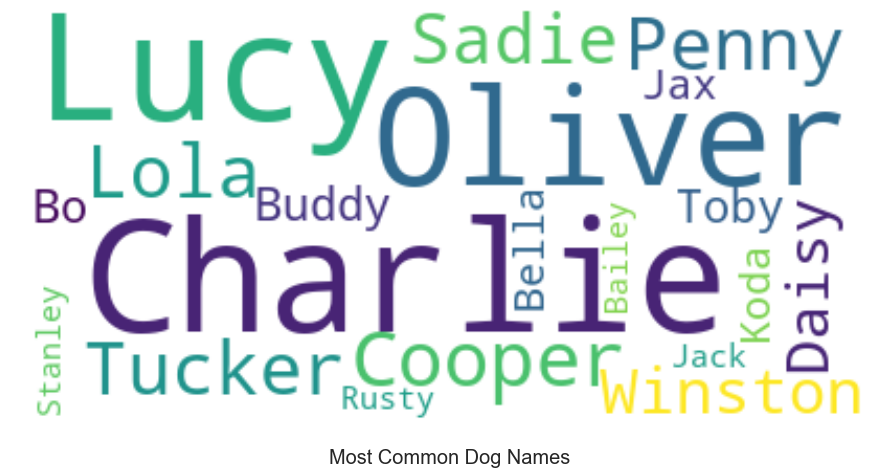

In [98]:
#Create the input text containing the dog names
names = list(filter(lambda name: name!='None',df.name))
text = ' '.join(names)
wordcloud = WordCloud(max_words = 20, background_color='white', colormap='viridis').generate(text)

#Draw the wordcloud
fig = plt.figure(figsize = [15,10])
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.margins(x=0,y=0)
plt.title('Most Common Dog Names',y=-0.1, fontdict={'fontsize':20});

### Most Popular Dog Breeds

<b>Objective:</b>

Create a treemap of the most common dog breeds.

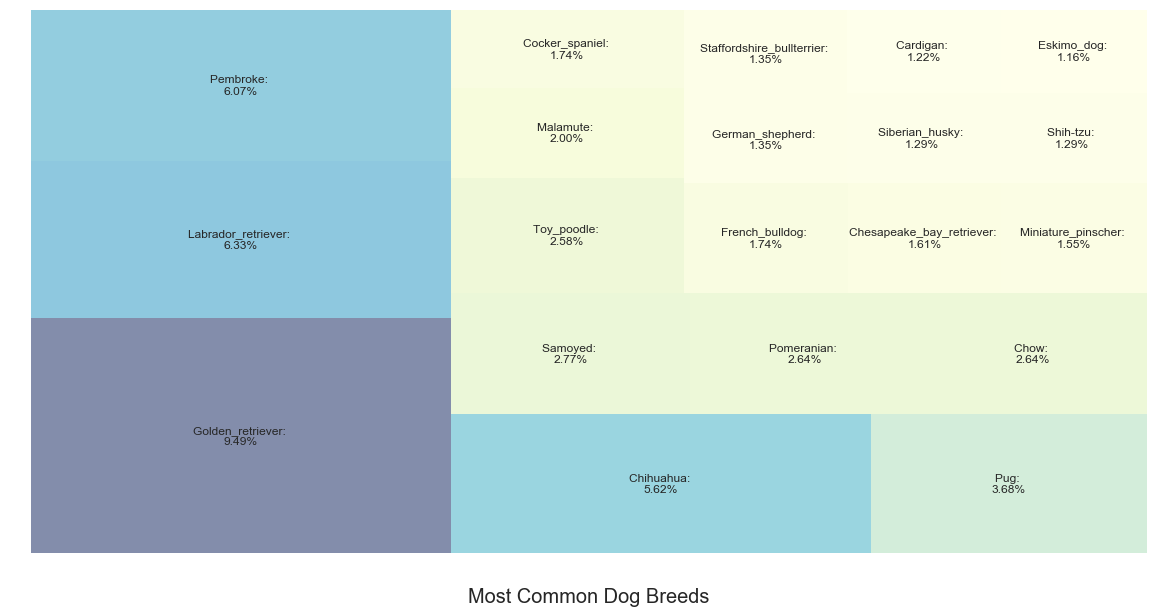

In [99]:
#Create the lists of values and labels
labels = df.breed.value_counts().head(20).keys()
values = df.breed.value_counts().head(20).values

#Create the list of percentages for each of the selected dog breeds
total = df.breed.value_counts().sum()
percentages = []
for value in values:
    percentages.append(value/total)

#Adjust the labels to include the values as well, to be more informative
labels_values = []
for label,percentage in zip(labels,percentages):
    labels_values.append(label + ': \n'+str(percentage*100)[:4]+'%')

#Build the treemap
fig = plt.figure(figsize = [20,10])
cmap = mpl.cm.YlGnBu
norm = mpl.colors.Normalize(vmin = min(values), vmax = max(values))
colors = [cmap(norm(value)) for value in values]
squarify.plot(sizes=values,label=labels_values, alpha=.5, color=colors);
plt.margins(x=0,y=0)
plt.title('Most Common Dog Breeds',y=-0.1, fontdict={'fontsize':20});
plt.axis('off');

### Rating Distribution

<b>Objective:</b>

Present how the dog ratings are distributed (what are the most/less common).

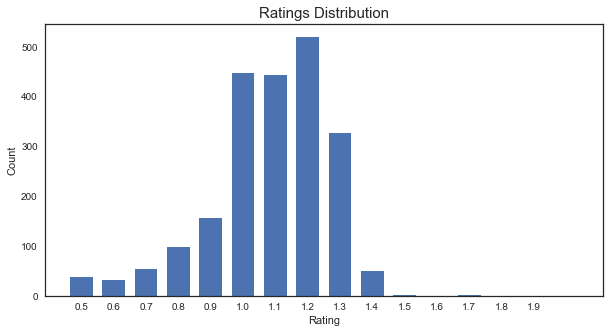

In [100]:
#Rating Distribution
plt.figure(figsize = [10,5])
bins = np.arange(0.45,2.15,0.1)
plt.xticks(np.arange(0.5,2,0.1))
plt.hist(data = df, x='rating',bins=bins,rwidth=0.7)
plt.ylabel('Count')
plt.xlabel('Rating')
plt.title('Ratings Distribution',fontdict={'fontsize':15});

### Highest Rated Breed

<b>Objective:</b>
Build a list of the dog breeds which are, on average, rated the highest.

In [101]:
#Select the 20 most common breeds
breeds = df.breed.value_counts().head(20).keys()

#Initialize the empty lists for ratings, retweets and favorite counts
#These will store the info for each of the 20 selected dog breeds
ratings = []
retweets = []
favorites = []

#Gather the data for the most common 20 dog breeds
for breed in breeds:
    ratings.append(df[df.breed == breed].groupby(['breed'])['rating'].mean()[0])
    retweets.append(df[df.breed == breed].groupby(['breed'])['retweet_count'].mean()[0])
    favorites.append(df[df.breed == breed].groupby(['breed'])['favorite_count'].mean()[0])

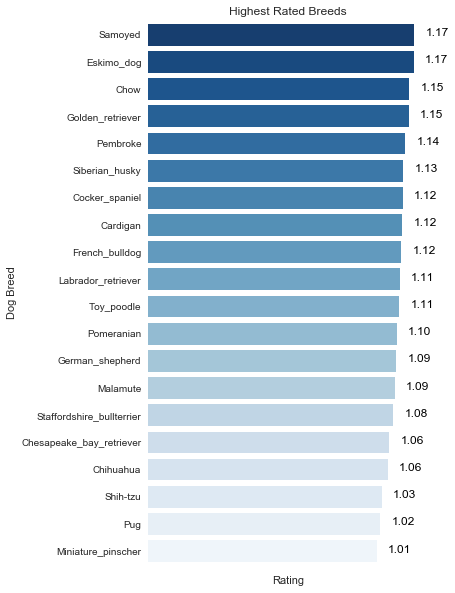

In [102]:
#Create the input dataframe storing breed and rating data
graph_df = pd.DataFrame()
graph_df['breed'] = breeds
graph_df['ratings'] = ratings

#Sort the input based on rating 
graph_df.sort_values(by='ratings',ascending=False,inplace=True)

#Build the barplot
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(5)
#Add the values next to the bars 
for i,v in enumerate(graph_df.ratings):
    ax.text(v+0.05, i+.05, str(v)[:4], color='black')
sns.barplot(x=graph_df.ratings, y=graph_df.breed,ax = ax, palette='Blues_r')
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set(title='Highest Rated Breeds', xlabel = 'Rating', ylabel = 'Dog Breed')
sns.despine(fig,bottom=True,left=True);

### Most Retweeted Breed

<b>Objective:</b>
Build a list of the dog breeds which are, on average, retweeted the most.

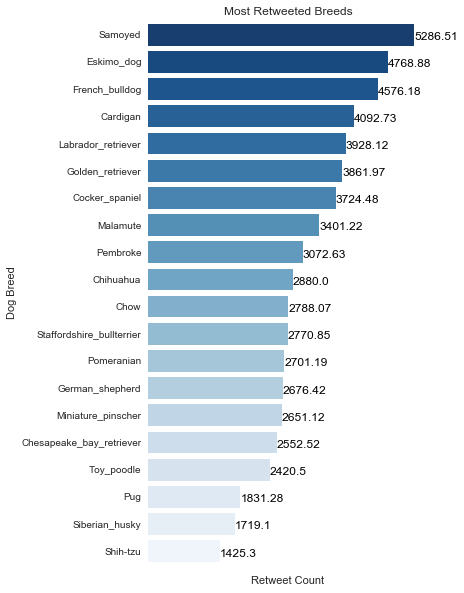

In [103]:
#Create the input dataframe storing breed and rating data
graph_df = pd.DataFrame()
graph_df['breed'] = breeds
graph_df['retweets'] = retweets

#Sort the input based on rating 
graph_df.sort_values(by='retweets',ascending=False,inplace=True)

#Build the barplot
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(5)
#Add the values next to the bars 
for i,v in enumerate(graph_df.retweets):
    ax.text(v+0.54, i+.2, str(v)[:7], color='black')
sns.barplot(x=graph_df.retweets, y=graph_df.breed,ax = ax, palette='Blues_r')
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set(title='Most Retweeted Breeds', xlabel = 'Retweet Count', ylabel = 'Dog Breed')
sns.despine(fig,bottom=True,left=True);

### Favorite Breed

<b>Objective:</b>
Build a list of the dog breeds which are, on average, added to favourite, the most.

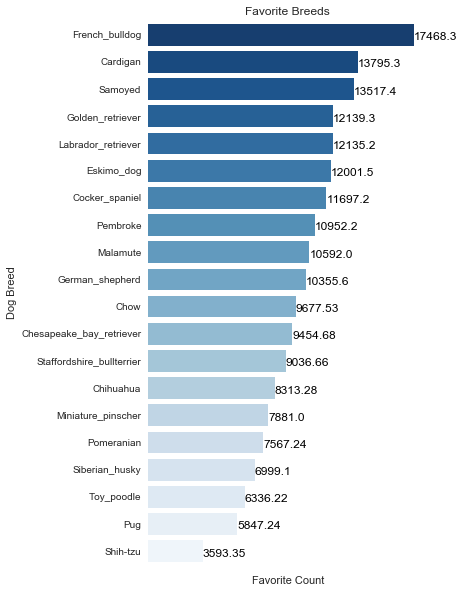

In [104]:
#Create the input dataframe storing breed and rating data
graph_df = pd.DataFrame()
graph_df['breed'] = breeds
graph_df['favorites'] = favorites

#Sort the input based on rating 
graph_df.sort_values(by='favorites',ascending=False,inplace=True)

#Build the barplot
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(5)
#Add the values next to the bars 
for i,v in enumerate(graph_df.favorites):
    ax.text(v+0.54, i+.2, str(v)[:7], color='black')
sns.barplot(x=graph_df.favorites, y=graph_df.breed,ax = ax, palette='Blues_r')
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set(title='Favorite Breeds', xlabel = 'Favorite Count', ylabel = 'Dog Breed')
sns.despine(fig,bottom=True,left=True);